In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
# https://www.geeksforgeeks.org/how-to-add-and-subtract-days-using-datetime-in-python/
from dateutil.relativedelta import relativedelta
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date_str = max_date[0]
max_date_str

'2017-08-23'

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
max_date_fmt = datetime.strptime(max_date_str, '%Y-%m-%d')
print(max_date_fmt)
print(type(max_date_fmt))

# Calculate the date one year from the last date in data set.
date_12m_prior = max_date_fmt - relativedelta(years=1)
print(date_12m_prior)
print(type(date_12m_prior))

# Perform a query to retrieve the data and precipitation scores
# https://stackoverflow.com/questions/17868743/doing-datetime-comparisons-in-filter-sqlalchemy
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_12m_prior).all()
precip


2017-08-23 00:00:00
<class 'datetime.datetime'>
2016-08-23 00:00:00
<class 'datetime.datetime'>


[('2016-08-24', 2.0),
 ('2016-08-25', 2.0),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.3),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 3.3),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.8),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 1.3),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.8),
 ('2016-09-10', 0.0),
 ('2016-09-11', 1.3),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.5),
 ('2016-09-14', 33.5),
 ('2016-09-15', 10.7),
 ('2016-09-16', 1.5),
 ('2016-09-17', 1.3),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.5),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 1.5),
 ('2016-09-27', 0.5),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07', 0.0),
 ('201

In [11]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# https://stackoverflow.com/questions/12047193/how-to-convert-sql-query-result-to-pandas-data-structure
connection = engine.connect()

precip_query = connection.execute("""
    SELECT 
       date,
       prcp
    FROM measurement
    Where date >= '2016-08-23'
    Order by date
    """
)

df = pd.DataFrame(precip_query.fetchall())
df.columns = precip_query.keys()
df

,date,prcp
0,2016-08-23,0.0
1,2016-08-23,3.8
2,2016-08-23,1.3
3,2016-08-23,NaN
4,2016-08-23,0.5
...,...,...
2225,2017-08-22,12.7
2226,2017-08-23,0.0
2227,2017-08-23,0.0
2228,2017-08-23,2.0


In [12]:
df_dropna = df.dropna()
df_clean = df_dropna.loc[df_dropna['prcp'] != 0]
df_clean

,date,prcp
1,2016-08-23,3.8
2,2016-08-23,1.3
4,2016-08-23,0.5
5,2016-08-23,45.5
6,2016-08-23,17.8
...,...,...
2220,2017-08-21,0.5
2222,2017-08-21,14.2
2225,2017-08-22,12.7
2228,2017-08-23,2.0


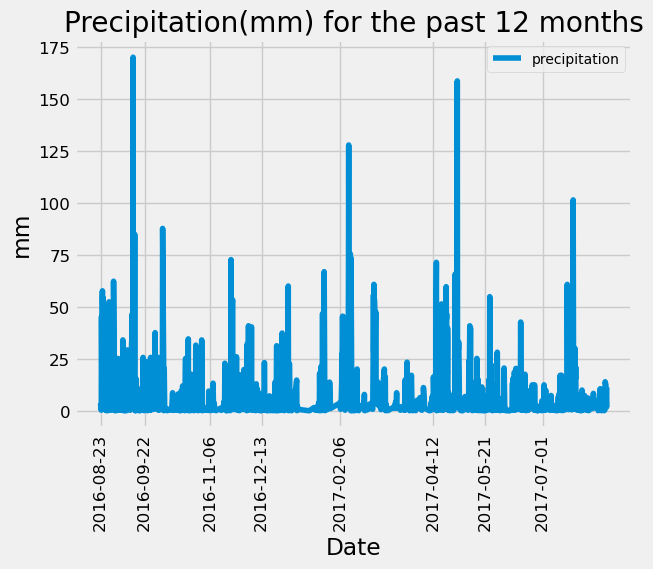

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
x = df_clean['date'].tolist()
x = np.asarray(x, dtype='datetime64[D]')

y = df_clean['prcp'].tolist()

ax = df_clean.plot(title='Precipitation(mm) for the past 12 months', 
                     fontsize=12,
                     xlabel='Date',
                     ylabel='mm',
                     legend=True,
                     rot=90
                     )

# force x date values to be datetime datatype https://stackoverflow.com/questions/26358200/xticks-by-pandas-plot-rename-with-the-string
ax.set_xticks(ticks=df_clean.index, labels=df_clean.date)

plt.locator_params(axis='x', nbins=8)
ax.legend(['precipitation'], fontsize=10)
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['prcp'].describe()

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(distinct(Station.station)))

total_stations[0]

(9,)

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_obs_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_obs_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Get max date
max_date_temp = session.query(Measurement.date).filter(Measurement.station=='USC00519281').order_by(Measurement.date.desc()).first()
max_date_temp_str = max_date_temp[0]
max_date_temp_str
max_date_temp_fmt = datetime.strptime(max_date_temp_str, '%Y-%m-%d')
print(max_date_temp_fmt)
print(type(max_date_temp_fmt))

# Calculate the date one year from the last date in data set.
date_12m_prior_temp = max_date_temp_fmt - relativedelta(years=1)
print(date_12m_prior_temp)
print(type(date_12m_prior_temp))


2017-08-18 00:00:00
<class 'datetime.datetime'>
2016-08-18 00:00:00
<class 'datetime.datetime'>


In [18]:
max_obs_station_id = station_obs_count[0][0]

result = connection.execute(f"SELECT MIN(tobs), MAX(tobs), avg(tobs) FROM measurement where station = '{max_obs_station_id}'")

for row in result:
    print(row)

(12.2, 29.4, 22.03582251082252)


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
connection = engine.connect()

temp_query = connection.execute(f"SELECT tobs FROM measurement where station = '{max_obs_station_id}' and date >= '2016-08-18'")

df_temp = pd.DataFrame(temp_query.fetchall())
df_temp.columns = temp_query.keys()

df_temp

,tobs
0,26.7
1,26.1
2,27.2
3,26.1
4,25.6
...,...
352,25.0
353,25.0
354,24.4
355,24.4


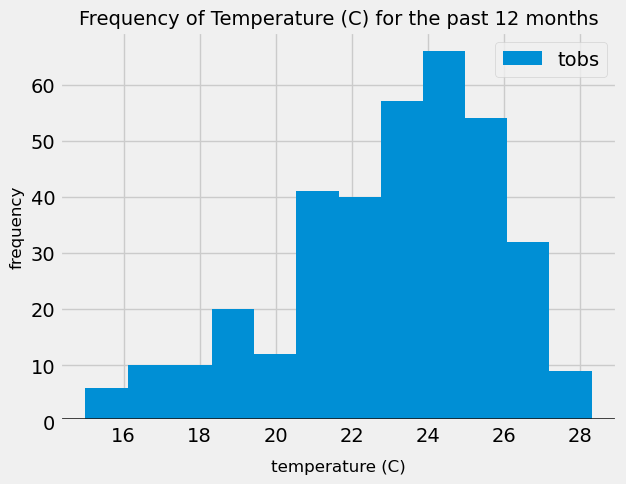

In [20]:
fig2, ax2 = plt.subplots()

# set x and y axes
x = df_temp['tobs'].tolist()

# y = df_temp['frequency'].tolist()

# Plot bar chart
ax2.hist(x, bins=12, label='tobs')
ax2.set_xlabel('temperature (C)',labelpad=10, fontsize=12)
ax2.set_ylabel('frequency', fontsize=12)
ax2.set_title('Frequency of Temperature (C) for the past 12 months', fontsize=14)

# ax2.tick_params(axis='x', labelrotation=90, labelbottom=True, labelsize=10, bottom=True)

plt.axhline(0, color='black')
# plt.axvline(min(x), color='black')
plt.legend()
plt.show()

# Close Session

In [21]:
# Close Session
session.close()
